In [215]:
import tensorflow as tf
import numpy as np
import os 
from matplotlib import pyplot as plt

In [216]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [217]:
#If you are using GPUS
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [218]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Filter out Bad Images - Remove unsupported extensions, very small images etc...

In [219]:
import cv2
import imghdr

In [220]:
data_dir = 'data'

In [221]:
image_extensions = ['jpg', 'jpeg', 'bmp', 'png']

In [224]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Load Classify Images in Data

In [225]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 189 files belonging to 2 classes.


In [226]:
data_itr = data.as_numpy_iterator()

In [227]:
batch = data_itr.next()

In [228]:
batch[0].shape

(32, 256, 256, 3)

Figuring out how the classes are labeled (Should be another way around it but hardcoding it for now)

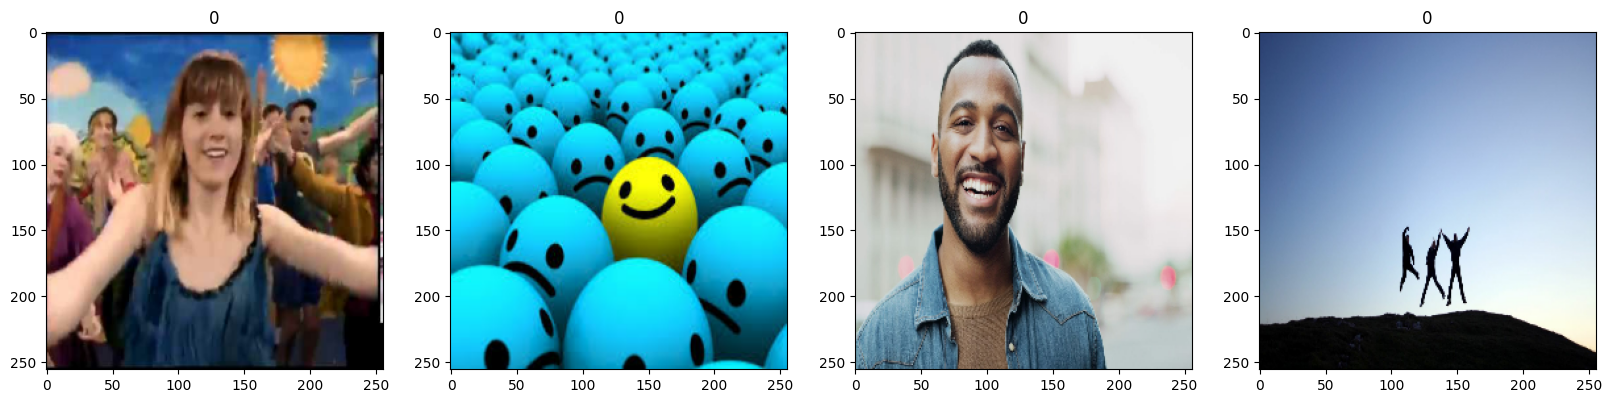

In [229]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scaling Data

In [230]:
data = data.map(lambda x, y: (x/255, y))

In [231]:
scaled_itr = data.as_numpy_iterator()

In [232]:
batch = scaled_itr.next()

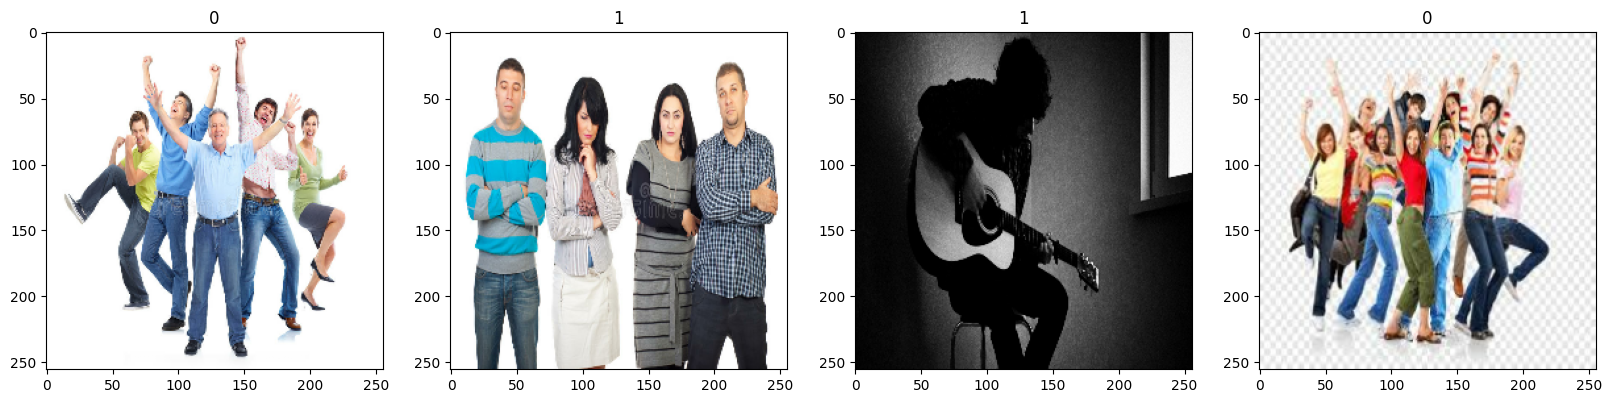

In [233]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Splitting Training, Validation & Testing Data

In [234]:
len(data) #data is the number of batches available (32 images/batch)

6

In [235]:
train_size = 3
val_size = 2
test_size = 1

In [236]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Building the Model

In [237]:
from tensorflow.keras.models import Sequential

In [238]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [239]:
model = Sequential()

In [240]:
model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

In [241]:
model.add(Conv2D(32, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

In [242]:
model.add(Conv2D(16, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())

In [243]:
model.add(Flatten())

In [244]:
model.add(Dense(256, activation="relu"))

In [245]:
model.add(Dense(1, activation="sigmoid"))

In [246]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [247]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 16)      

Logging

In [249]:
log_dir = 'logs' 

In [250]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

Training

In [251]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 8s 2s/step - loss: 1.1621 - accuracy: 0.5938 - val_loss: 0.8485 - val_accuracy: 0.4844
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 0.8658 - accuracy: 0.3542 - val_loss: 0.6611 - val_accuracy: 0.8125
Epoch 3/20
3/3 [==============================] - 10s 3s/step - loss: 0.6538 - accuracy: 0.6458 - val_loss: 0.5630 - val_accuracy: 0.6875
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.6369 - accuracy: 0.6042 - val_loss: 0.5914 - val_accuracy: 0.8750
Epoch 5/20
3/3 [==============================] - 8s 2s/step - loss: 0.5606 - accuracy: 0.7708 - val_loss: 0.4810 - val_accuracy: 0.7656
Epoch 6/20
3/3 [==============================] - 8s 2s/step - loss: 0.5198 - accuracy: 0.7604 - val_loss: 0.4108 - val_accuracy: 0.7969
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 0.4712 - accuracy: 0.7292 - val_loss: 0.2975 - val_accuracy: 0.9062
Epoch 8/20
3/3 [========================

In [252]:
hist.history

{'loss': [1.162079095840454,
  0.8657872080802917,
  0.6538117527961731,
  0.6368728876113892,
  0.5605586171150208,
  0.5197893977165222,
  0.47117483615875244,
  0.36066874861717224,
  0.3583192825317383,
  0.2971001863479614,
  0.21323810517787933,
  0.24064268171787262,
  0.17865286767482758,
  0.1271609663963318,
  0.08152893930673599,
  0.05313826724886894,
  0.023766621947288513,
  0.024945007637143135,
  0.024113396182656288,
  0.005052001681178808],
 'accuracy': [0.59375,
  0.3541666567325592,
  0.6458333134651184,
  0.6041666865348816,
  0.7708333134651184,
  0.7604166865348816,
  0.7291666865348816,
  0.90625,
  0.8854166865348816,
  0.8958333134651184,
  0.9270833134651184,
  0.90625,
  0.96875,
  0.9479166865348816,
  0.9895833134651184,
  0.9895833134651184,
  0.9895833134651184,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.8484923839569092,
  0.6611285209655762,
  0.5629854202270508,
  0.5914275646209717,
  0.48104962706565857,
  0.4107993245124817,
  0.29747146368026733,
  0.4

Plotting Performance

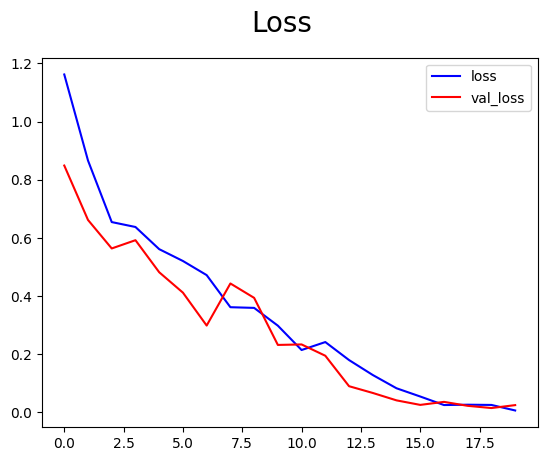

In [253]:
#loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

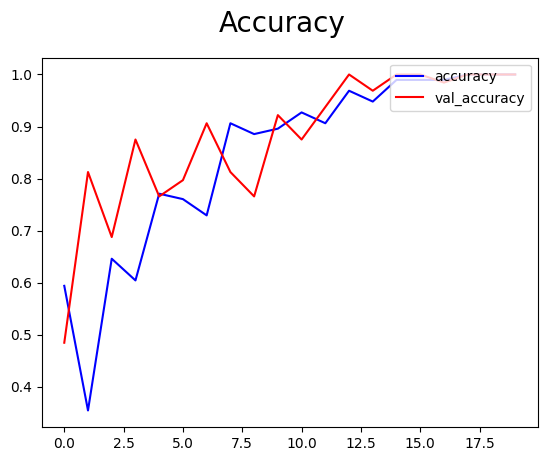

In [254]:
#accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

Evaluating Performance

In [255]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [256]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [257]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_hat = model.predict(x)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

1/1 [==============================] - 0s 243ms/step


In [258]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:0.9166666865348816, Accuracy:0.9655172228813171


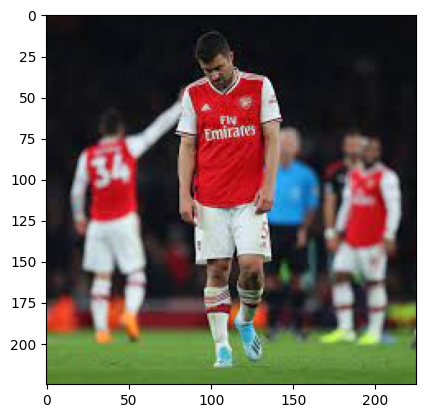

In [290]:
img = cv2.imread('sadtest3.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

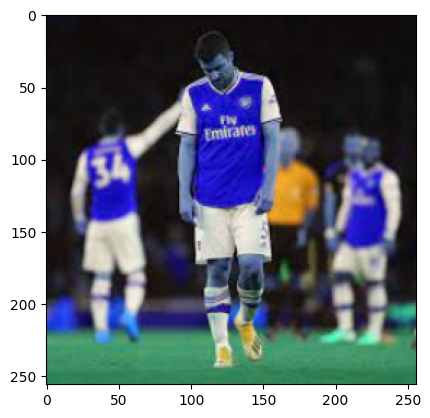

In [291]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [292]:
resize.shape

TensorShape([256, 256, 3])

In [293]:
y_hat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 38ms/step


In [294]:
y_hat

array([[0.99258107]], dtype=float32)

In [306]:
def output(y_hat):
    if y_hat < 0.5:
        print(f'Happy Picture!')
    else:
        print(f'Sad Picture :(')

In [308]:
output(y_hat)

Sad Picture :(


Saving the Model

In [309]:
from tensorflow.keras.models import load_model

In [310]:
model.save(os.path.join('models', 'binarySentiment.h5'))

In [311]:
new_model = load_model(os.path.join('models', 'binarySentiment.h5'))

In [312]:
new_y_hat = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 85ms/step


In [313]:
output(new_y_hat)

Sad Picture :(
